# Open Data NYC - Property Valuation EDA

In [162]:
from collections import defaultdict
from configparser import ConfigParser
from geopy import geocoders
from matplotlib import pyplot as plt
import folium
import geopandas as gpd
import json
import numpy as np
import pandas as pd
import os
from scipy import stats
import seaborn as sns
import sys

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth',100)

## Load Data & Clean Up

In [163]:
def get_base_path():
    cwd = os.path.basename(os.getcwd())
    if cwd.lower() != 'airbnb-price-predictor':
        return os.path.dirname(os.getcwd())
    else:
        return os.getcwd()

In [164]:
config = ConfigParser()
config_path = get_base_path() + '/config.ini'
# print("configuring from", config_path)
config.read(config_path)

['/Users/kmazurczyk/Desktop/AirBnB-Price-Predictor/config.ini']

**Load and collate Property Valuation CSVs that were generated from PropertyValuationAPI.py**

**Load a supplementary CSV with building classification codes that will help classify residential properties.**

In [165]:
df = pd.DataFrame()
data_directory = get_base_path() + config['DATA_SOURCES']['data_dir']

# collect valuations_files
valuation_file_names = config['DATA_SOURCES']['valuations_csv']

for root, dirs, files in os.walk(data_directory):
    for file in files:
        if 'ValuationsData' in file:
            temp_df = pd.read_csv(root+file, index_col = 0, low_memory = False)
            df = pd.concat([df, temp_df], ignore_index = True)

    building_file_name = config['DATA_SOURCES']['nyc_building_codes_csv']
    building_codes_df = pd.read_csv(root + building_file_name + '.csv')

df = df.set_index('bldg_class').join(building_codes_df.set_index('BUILDING_CODE'), how='left' ).reset_index()
df.columns = [str.lower(c) for c in df.columns]

In [166]:
# drop id columns that we don't need
df.drop(['parid','block','lot','year','period','last_modified','is_residential'],axis=1,inplace=True)
df.head()

,bldg_class,boro,housenum_lo,housenum_hi,units,coop_apts,street_name,zip_code,owner,land_area,yrbuilt,yralt1_range,yralt2_range,num_bldgs,bld_story,gross_sqft,zoning,curmkttot,newdrop,noav,aptno,valref,classification,description
0,D4,1,80,80,1652,1641,GOLD STREET,10038,SOUTHBRIDGE TOWERS INC,357935,1971,0,0,10,6.0,2163399,R8,367448000,0.0,0,NaN,NaN,ELEVATOR APARTMENTS,ELEVATOR COOPERATIVE
1,D6,1,20,70,1947,1934,MADISON STREET,10038,NYC CITY HSG AUTRHORITY,781000,1950,0,0,12,17.0,1264820,R7-2,171964000,0.0,0,NaN,NaN,ELEVATOR APARTMENTS,ELEVATOR APT; FIREPROOF WITH STORES
2,S4,1,25,25,5,4,MADISON STREET,10038,27 ST. JAMES HOLDINGS LLC,1024,1905,0,0,1,5.0,4765,R7-2,1163000,0.0,0,NaN,NaN,PRIMARILY RES. - MIXED USE,PRIMARILY 4 FAMILY WITH 1 STORE OROFFICE
3,C7,1,35,35,12,10,MADISON STREET,10038,METRO CITY ACQUISITION LLC,2000,1910,0,0,1,4.0,6924,R7-2,1101000,0.0,0,NaN,NaN,WALK UP APARTMENTS,WALK-UP APT. OVER SIX FAMILIES WITH STORES
4,S4,1,37,37,5,4,MADISON STREET,10038,THREE BROTHERS REALTY,900,1905,0,0,1,3.0,2800,R7-2,926000,0.0,0,NaN,NaN,PRIMARILY RES. - MIXED USE,PRIMARILY 4 FAMILY WITH 1 STORE OROFFICE


### Summary Statistics

In [167]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900307 entries, 0 to 900306
Data columns (total 24 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   bldg_class      900307 non-null  object 
 1   boro            900307 non-null  int64  
 2   housenum_lo     883978 non-null  object 
 3   housenum_hi     863136 non-null  object 
 4   units           900307 non-null  int64  
 5   coop_apts       900307 non-null  int64  
 6   street_name     900262 non-null  object 
 7   zip_code        900294 non-null  object 
 8   owner           900293 non-null  object 
 9   land_area       900307 non-null  int64  
 10  yrbuilt         900307 non-null  int64  
 11  yralt1_range    900307 non-null  int64  
 12  yralt2_range    900307 non-null  int64  
 13  num_bldgs       900307 non-null  int64  
 14  bld_story       900307 non-null  float64
 15  gross_sqft      900307 non-null  int64  
 16  zoning          900307 non-null  object 
 17  curmkttot 

In [168]:
# Fix Data Types
df[['boro','newdrop']] = df[['boro','newdrop']].astype('object')

In [169]:
# Objects and Categoricals
str_columns = df.select_dtypes(include='object').columns

n_uniques = []
n_nulls = []

for col in str_columns:
        # Get value counts and basic stats
        n_uniques.append(df[col].nunique())
        n_nulls.append(df[col].isnull().sum())

str_summary = pd.DataFrame({'columns':str_columns,
                            'n_unique_values':n_uniques,
                            'n_nulls':n_nulls})

str_summary.sort_values('n_unique_values')

,columns,n_unique_values,n_nulls
11,valref,1,899792
8,newdrop,2,2
9,noav,2,0
1,boro,5,0
12,classification,7,0
7,zoning,40,0
0,bldg_class,54,0
13,description,54,0
5,zip_code,194,13
4,street_name,8104,45


In [170]:
# Numerics
num_columns = df.select_dtypes(include=np.number).columns.to_list()
df[num_columns].describe().round(2).T


,count,mean,std,min,25%,50%,75%,max
units,900307.0,3.54,29.83,0.0,1.0,1.0,2.0,1.094800e+04
coop_apts,900307.0,3.47,29.68,0.0,1.0,1.0,2.0,1.091400e+04
land_area,900307.0,6929.05,48061.19,0.0,1946.0,2500.0,4000.0,2.310884e+07
yrbuilt,900307.0,1804.49,507.19,0.0,1920.0,1931.0,1964.0,2.023000e+03
yralt1_range,900307.0,96.13,429.21,0.0,0.0,0.0,0.0,9.889000e+03
yralt2_range,900307.0,15.40,175.39,0.0,0.0,0.0,0.0,3.033000e+03
num_bldgs,900307.0,1.02,2.73,0.0,1.0,1.0,1.0,2.004000e+03
bld_story,900307.0,2.99,4.00,0.0,2.0,2.0,3.0,3.425900e+02
gross_sqft,900307.0,3629.95,28627.25,0.0,1216.0,1760.0,2560.0,1.354011e+07
curmkttot,900307.0,1108881.81,4141409.53,0.0,591000.0,811000.0,1140800.0,2.010493e+09


### Encode Factors & Binary Variables

In [171]:
# valref, noav, newdrop binaries
df[['valref','noav','newdrop']] = df.loc[:,['valref','noav','newdrop']].map(lambda x: 'Y' if x in ('Y',1) else 'N')

In [172]:
# Boro Code to Name
boroughs = {1:'Manhattan', 2:'Bronx', 3:'Brooklyn', 4:'Queens', 5:'Staten'}
df['boro'] = df['boro'].map(boroughs)

In [173]:
# ZIP CODES
# it would be useful to use zip code as a grouping. but a mix of 5 and 9 digit codes increases the cardinality, reduce to 5 digits
df['zip_code'] = df['zip_code'].apply(lambda x: str(x)[:5])
df['zip_code'].nunique()

185

### Missing Data: Zero & Null
**I noticed many fields with 0.0 when I loaded the data. Let's assess zeroes and null density.**

In [174]:
# ZEROES
df[df[num_columns] == 0].count(axis = 0).sort_values(ascending=False)

yralt2_range      893422
yralt1_range      857287
land_area          81610
yrbuilt            65674
bld_story          57787
num_bldgs          35146
coop_apts          22808
gross_sqft         21775
units              21627
curmkttot           1059
zoning                 0
classification         0
valref                 0
aptno                  0
noav                   0
newdrop                0
bldg_class             0
boro                   0
owner                  0
zip_code               0
street_name            0
housenum_hi            0
housenum_lo            0
description            0
dtype: int64

In [175]:
# NULLS
df.isna().sum().sort_values(ascending=False)

aptno             745348
housenum_hi        37171
housenum_lo        16329
street_name           45
owner                 14
bldg_class             0
bld_story              0
classification         0
valref                 0
noav                   0
newdrop                0
curmkttot              0
zoning                 0
gross_sqft             0
yralt2_range           0
num_bldgs              0
boro                   0
yralt1_range           0
yrbuilt                0
land_area              0
zip_code               0
coop_apts              0
units                  0
description            0
dtype: int64

##### Year Columns
We'll drop yrbuilt, yralt1_range and yralt2_range due to data quality. In addition to many missing values, date ranges extend into future and early past. Evidence below.

In [176]:
df.loc[:,['yrbuilt','yralt1_range','yralt2_range']].describe()

,yrbuilt,yralt1_range,yralt2_range
count,900307.000000,900307.000000,900307.000000
mean,1804.490797,96.125789,15.395947
std,507.187441,429.205711,175.385483
min,0.000000,0.000000,0.000000
25%,1920.000000,0.000000,0.000000
50%,1931.000000,0.000000,0.000000
75%,1964.000000,0.000000,0.000000
max,2023.000000,9889.000000,3033.000000


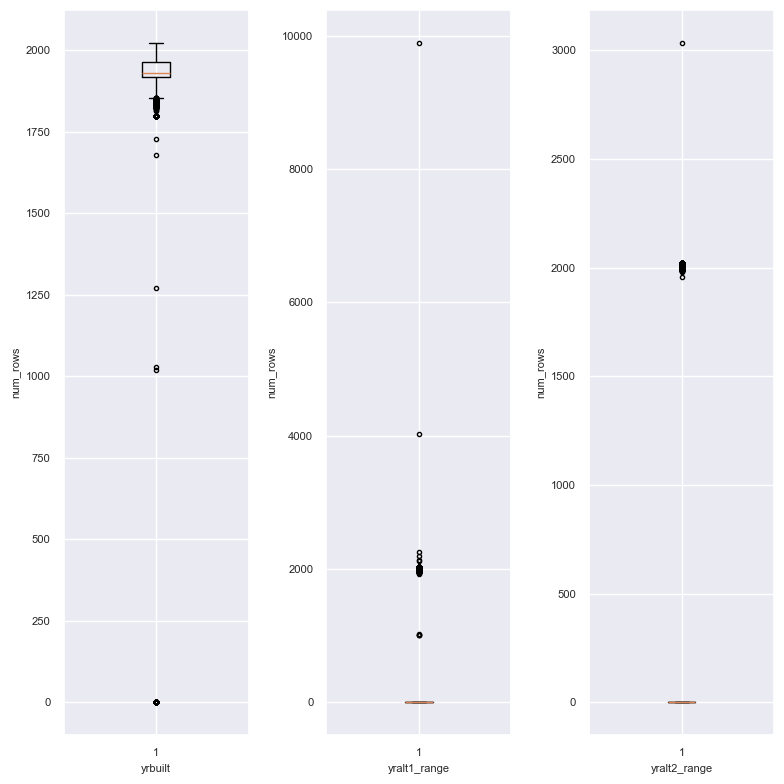

In [177]:
%matplotlib inline
plt.rcParams.update({'axes.labelsize':8, 'ytick.labelsize':8, 'xtick.labelsize':8})

year_columns = ['yrbuilt','yralt1_range','yralt2_range']

fig, axs = plt.subplots(1,3)
for i in range(len(year_columns)):
    axs[i].boxplot(df[year_columns[i]], sym='.')
    axs[i].set_ylabel('num_rows')
    axs[i].set_xlabel(year_columns[i])
plt.tight_layout()

In [178]:
df.drop(year_columns, axis=1, inplace=True)

##### Square Footage

* Land area: Zero land area is correct for apartment/condo properties.
* Gross sq ft: Highlighted a few classes that are not relevant to our project.
    * Drop vacant lots (classification = 'VACANT LAND')
    * Drop communal condo areas (description = 'CONDO; COMML.UNIT OF 2-10 UNIT BLDG.') 
    * For the remaining zeroes, impute a median.

In [179]:
df['land_area_is_zero'] = (df['land_area'] == 0)
df['gross_sqft_is_zero'] = (df['gross_sqft'] == 0)
df['curmkttot_is_zero'] = (df['curmkttot'] == 0)

pivot = pd.pivot_table(
    df,
    values=['land_area_is_zero','gross_sqft_is_zero','curmkttot_is_zero','curmkttot'],
    index=['classification','description'],
    aggfunc={'land_area_is_zero':'sum','gross_sqft_is_zero':'sum','curmkttot_is_zero':'sum','curmkttot':'mean'}
)

pivot.sort_values(['gross_sqft_is_zero','land_area_is_zero'],ascending=False).head(10)

curmkttot  curmkttot_is_zero  gross_sqft_is_zero  land_area_is_zero
classification       description                                                                                                            
VACANT LAND          ZONED RESIDENTIAL; NOT MANHATTAN                 4.214528e+05                596               18802                 47
                     ZONED COMMERCIAL OR MANHATTAN RESIDENTIAL        7.027373e+05                 88                2586                 17
CONDOMINIUMS         CONDO; COMML.UNIT OF 2-10 UNIT BLDG.             3.793247e+05                  2                 193                443
VACANT LAND          ZONED PRIMARILY RESIDENTIAL; NOT MANHATTAN       1.394653e+07                 14                 170                  0
CONDOMINIUMS         CONDO; RESIDENTIAL UNIT IN ELEVATOR BLDG.        2.218912e+05                  8                   3              58601
ONE FAMILY DWELLINGS TWO STORIES - DETACHED SM OR MID                 9.018303e+05                 11                   3                  0
CONDOMINIUMS         CONDO; RESIDENTIAL UNIT IN 2-10 UNIT BLDG.       3.600996e+05                  9                   2               6712
                     CONDO; RESID.UNIT OF 1-3 UNIT BLDG-ORIG CLASS 1  1.434967e+06                  0                   2                838
ELEVATOR APARTMENTS  ELEVATOR APT; MISCELLANEOUS                      8.968116e+06                  2                   2                  2
                     ELEVATOR APT; FIREPROOF WITHOUT STORES           1.365452e+07                 25                   2                  0

In [180]:
df = df.loc[df['classification'] != 'VACANT LAND',:]
df = df.loc[df['description'] != 'CONDO; COMML.UNIT OF 2-10 UNIT BLDG.',:]

**Gross Sq Ft - Imputation**
* Below gross square footage is highly skewed, even when segmented by class and log scaled. So we will impute a median.

In [181]:
df['gross_sqft'].describe().round(2)

count      877597.00
mean         3722.42
std         28989.36
min             0.00
25%          1248.00
50%          1792.00
75%          2598.00
max      13540113.00
Name: gross_sqft, dtype: float64

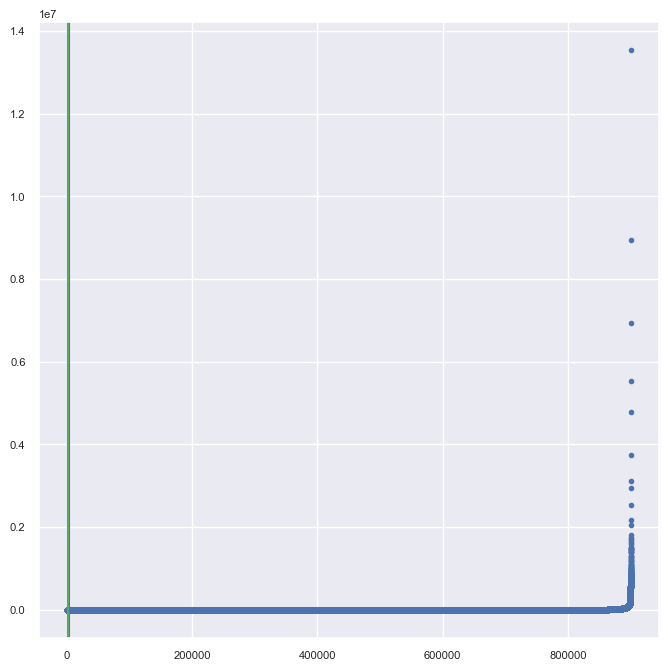

In [182]:
%matplotlib inline
plt.scatter(x=df['gross_sqft'].index, y=df['gross_sqft'].sort_values(),marker='.')
plt.axvline(x=df['gross_sqft'].mean(),color='r')
plt.axvline(x=df['gross_sqft'].median(),color='g')

In [183]:
df['imputed_gross_sqft_median'] = df['gross_sqft'].where(df['gross_sqft'] != 0, df['gross_sqft'].median())

In [184]:
# validate no significant impact to distribution
df[['gross_sqft','imputed_gross_sqft_median']].describe()

,gross_sqft,imputed_gross_sqft_median
count,8.775970e+05,8.775970e+05
mean,3.722420e+03,3.722469e+03
std,2.898936e+04,2.898935e+04
min,0.000000e+00,1.000000e+00
25%,1.248000e+03,1.248000e+03
50%,1.792000e+03,1.792000e+03
75%,2.598000e+03,2.598000e+03
max,1.354011e+07,1.354011e+07


##### Current Market Value
* as above, we'll impute median

In [185]:
df.loc[df['curmkttot_is_zero'] == 1,:].sample(5)

,bldg_class,boro,housenum_lo,housenum_hi,units,coop_apts,street_name,zip_code,owner,land_area,num_bldgs,bld_story,gross_sqft,zoning,curmkttot,newdrop,noav,aptno,valref,classification,description,land_area_is_zero,gross_sqft_is_zero,curmkttot_is_zero,imputed_gross_sqft_median
470222,D7,Queens,56-02,NaN,52,47,31 AVENUE,11377,31 AVE REALTY LLC,33153,1,4.0,111263,R5,0,N,N,NaN,N,ELEVATOR APARTMENTS,ELEVATOR APT; SEMI-FIREPROOF WITH STORES,False,False,True,111263
353897,C1,Brooklyn,122,NaN,12,12,BAY 26 STREET,11214,122 BAY REALTY LLC,9667,1,2.0,12616,R5,0,N,N,NaN,N,WALK UP APARTMENTS,OVER SIX FAMILIES WITHOUT STORES,False,False,True,12616
901,D7,Manhattan,30,NaN,118,117,NORFOLK STREET,10002,CPC NORFOLK SENIOR HOUSING DEVELOPMENT F UND,6609,0,16.0,86333,R9-1,0,N,N,NaN,N,ELEVATOR APARTMENTS,ELEVATOR APT; SEMI-FIREPROOF WITH STORES,False,False,True,86333
668732,A5,Queens,169-19,NaN,1,1,90 AVENUE,11432,JAMAICA SOUTH CORPORATION,2500,1,2.5,1545,R6A,0,N,N,NaN,N,ONE FAMILY DWELLINGS,ONE FAMILY ATTACHED OR SEMI-DETACHED,False,False,True,1545
451574,D7,Queens,23-23,NaN,17,16,30 ROAD,11102,23-23 ASTORIA LLC,6228,1,5.0,18863,R6B,0,N,N,NaN,N,ELEVATOR APARTMENTS,ELEVATOR APT; SEMI-FIREPROOF WITH STORES,False,False,True,18863


In [186]:
pivot = pd.pivot_table(
    df,
    values=['curmkttot_is_zero','curmkttot'],
    index=['boro','classification','description'],
    aggfunc={'curmkttot_is_zero':'sum','curmkttot':np.median}
)

pivot.sort_values('curmkttot_is_zero',ascending=False).head(20)

/var/folders/m7/3zdgjklj6csfvb86kltb13hr0000gn/T/ipykernel_56108/4013946604.py:1: FutureWarning: The provided callable <function median at 0x103f49790> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  pivot = pd.pivot_table(


curmkttot  curmkttot_is_zero
boro      classification             description                                                              
Brooklyn  WALK UP APARTMENTS         THREE FAMILIES                               1491000.0                 28
                                     OVER SIX FAMILIES WITHOUT STORES             1538000.0                 27
                                     FOUR FAMILIES                                 699800.0                 24
          ELEVATOR APARTMENTS        ELEVATOR APT; SEMI-FIREPROOF WITHOUT STORES  3813500.0                 21
Queens    ELEVATOR APARTMENTS        ELEVATOR APT; SEMI-FIREPROOF WITH STORES     4958000.0                 18
Brooklyn  ELEVATOR APARTMENTS        ELEVATOR APT; SEMI-FIREPROOF WITH STORES     4199000.0                 16
                                     ELEVATOR APT; FIREPROOF WITH STORES          4301000.0                 16
Queens    ELEVATOR APARTMENTS        ELEVATOR APT; FIREPROOF WITH STORES          3345000.0                 14
Brooklyn  ELEVATOR APARTMENTS        ELEVATOR APT; FIREPROOF WITHOUT STORES       5120500.0                 12
Bronx     ELEVATOR APARTMENTS        ELEVATOR APT; SEMI-FIREPROOF WITH STORES     3618000.0                 12
Brooklyn  WALK UP APARTMENTS         FIVE TO SIX FAMILIES                         1015100.0                 12
Manhattan ELEVATOR APARTMENTS        ELEVATOR APT; FIREPROOF WITHOUT STORES       6730000.0                  9
Brooklyn  CONDOMINIUMS               CONDO; RESIDENTIAL UNIT IN 2-10 UNIT BLDG.    268662.5                  8
          PRIMARILY RES. - MIXED USE PRIMARILY 2 FAMILY WITH 1 STORE OR OFFICE    1501000.0                  8
          TWO FAMILY DWELLINGS       TWO FAMILY BRICK                             1099000.0                  8
Manhattan CONDOMINIUMS               CONDO; RESIDENTIAL UNIT IN ELEVATOR BLDG.     269156.5                  7
Brooklyn  PRIMARILY RES. - MIXED USE PRIMARILY 5-6 FAMILY WITH 1 STORE OR OFFICE   970700.0                  7
Manhattan ELEVATOR APARTMENTS        ELEVATOR APT; SEMI-FIREPROOF WITH STORES     5207000.0                  6
Bronx     CONDOMINIUMS               CONDO; RESIDENTIAL UNIT IN 1-3 STORY BLDG.    380571.0                  6
Brooklyn  CONDOMINIUMS               CONDO; RESIDENTIAL UNIT IN 1-3 STORY BLDG.    672556.0                  5

In [187]:
df['imputed_curmkttot_median'] = df['curmkttot'].where(df['curmkttot'] != 0, df['curmkttot'].median())

In [188]:
# confirm no significant changes in distribution
df[['curmkttot','imputed_curmkttot_median']].describe().round(2)

,curmkttot,imputed_curmkttot_median
count,8.775970e+05,8.775970e+05
mean,1.123276e+06,1.123612e+06
std,3.491477e+06,3.491408e+06
min,0.000000e+00,1.900000e+01
25%,6.060000e+05,6.070000e+05
50%,8.220000e+05,8.220000e+05
75%,1.152000e+06,1.152000e+06
max,1.502480e+09,1.502480e+09


##### Addresses
* We require complete addresses to map an AirBNB listing to a city property valuation. Missing values will impact the precision of our matches.

* NaN Apartment Numbers (aptno) is correct - records are single family homes, townhouses, and entire apartment buildings where an apartment number would be n/a

* Missing house numbers (housenum_lo, housenum_hi) and street names (street_name) are going to prevent us from matching records to AirBNB hosts
    * will still leave the data in for EDA
* Missing zip codes should be nulled, not zero, until they can be filled using Google GeoCoding

In [189]:
df.loc[df['housenum_lo'].isna(),:].head()

,bldg_class,boro,housenum_lo,housenum_hi,units,coop_apts,street_name,zip_code,owner,land_area,num_bldgs,bld_story,gross_sqft,zoning,curmkttot,newdrop,noav,aptno,valref,classification,description,land_area_is_zero,gross_sqft_is_zero,curmkttot_is_zero,imputed_gross_sqft_median,imputed_curmkttot_median
565,D7,Manhattan,NaN,NaN,12,10,EAST BROADWAY,10002,"201 EB DEVELOPMENT III,LLC",4375,1,7.0,22694,R7-2,1587000,N,N,NaN,N,ELEVATOR APARTMENTS,ELEVATOR APT; SEMI-FIREPROOF WITH STORES,False,False,False,22694,1587000
620,D6,Manhattan,NaN,NaN,403,400,CLINTON STREET,10002,SOUTHEAST GRND ST ETAL,36905,2,26.0,225000,R8,52702000,N,N,NaN,N,ELEVATOR APARTMENTS,ELEVATOR APT; FIREPROOF WITH STORES,False,False,False,225000,52702000
903,D7,Manhattan,NaN,NaN,380,378,SUFFOLK STREET,10002,CPC ONE LLC,25792,1,32.0,378755,R9-1,0,N,N,NaN,N,ELEVATOR APARTMENTS,ELEVATOR APT; SEMI-FIREPROOF WITH STORES,False,False,True,378755,822000
1092,D7,Manhattan,NaN,NaN,7,6,CLINTON STREET,0,14 CLINTON HOLDINGS LLC,2000,0,6.0,8289,R7A,0,N,N,NaN,N,ELEVATOR APARTMENTS,ELEVATOR APT; SEMI-FIREPROOF WITH STORES,False,False,True,8289,822000
1448,D6,Manhattan,NaN,NaN,12,10,AVENUE C,10009,"113 WILLOW AVENUE REALTY COMPANY, LLC.",2362,0,0.0,9448,R7A,3237000,N,N,NaN,N,ELEVATOR APARTMENTS,ELEVATOR APT; FIREPROOF WITH STORES,False,False,False,9448,3237000


In [190]:
df.loc[(df['street_name'].isna()),:].head()

,bldg_class,boro,housenum_lo,housenum_hi,units,coop_apts,street_name,zip_code,owner,land_area,num_bldgs,bld_story,gross_sqft,zoning,curmkttot,newdrop,noav,aptno,valref,classification,description,land_area_is_zero,gross_sqft_is_zero,curmkttot_is_zero,imputed_gross_sqft_median,imputed_curmkttot_median
71557,D1,Bronx,NaN,NaN,43,43,NaN,nan,E&G WALTON DEVELOPERS LLC,5000,1,8.0,26147,R8,3206000,N,N,NaN,N,ELEVATOR APARTMENTS,ELEVATOR APT; SEMI-FIREPROOF WITHOUT STORES,False,False,False,26147,3206000
78014,D9,Bronx,NaN,NaN,97,96,NaN,nan,"2050 G.C. HOUSING DEVELOPMENT FUND COMPA NY, INC.",10414,1,13.0,86173,R8,12229000,N,N,NaN,N,ELEVATOR APARTMENTS,ELEVATOR APT; MISCELLANEOUS,False,False,False,86173,12229000
142971,A1,Bronx,NaN,NaN,1,1,NaN,nan,"BROWN, PETER",4180,1,2.0,2500,R2,918000,N,N,NaN,N,ONE FAMILY DWELLINGS,TWO STORIES - DETACHED SM OR MID,False,False,False,2500,918000
475798,C0,Queens,NaN,NaN,3,3,NaN,nan,"CHIME, TENZIN",2200,1,3.0,3300,R5,1729000,N,N,NaN,N,WALK UP APARTMENTS,THREE FAMILIES,False,False,False,3300,1729000
570299,D7,Queens,NaN,NaN,44,42,NaN,nan,EAST WEST PLAZA LLC,9480,1,0.0,46915,R6,0,N,N,NaN,N,ELEVATOR APARTMENTS,ELEVATOR APT; SEMI-FIREPROOF WITH STORES,False,False,True,46915,822000


In [191]:
# zeroes to be removed from zip code
filt = ~(df['zip_code'] == '0') & ~(df['zip_code'] == '0.0')
print(filt.value_counts())
df['zip_code'] = df['zip_code'].where(filt,pd.NA)


zip_code
True     877316
False       281
Name: count, dtype: int64


In [192]:
# zipcodes - zeroes filled with NAN
filt = ~(df['zip_code'] == '0') & ~(df['zip_code'] == '0.0')
zipcode = df['zip_code'].unique().tolist()
df['zip_code'].isna().value_counts()

zip_code
False    877316
True        281
Name: count, dtype: int64

##### Building Features
* we are interested in the number of living spaces on a property. 
* units refers to any partitioned space, residential/commercial on a property. coop_apts appears to refer to the true number of residences. therefore units can be dropped.
* we engineer a feature 'residential_units' that uses coop_apts and imputes 1 unit for missing values
    * there are only missing coop_apts values on condos and single family dwellings, since these are single residences. 
        * we can accurately impute 1 instead of 0 to reflect 1 residential space.
* the variety of units also means we need to scale continuous values accordingly - gross_sqft, curmkttot
* num_bldings has a high number of missing values drop because residential_units will better reflect the feature of interest.

In [193]:
# missing values on coop_apts is limited to condos and single family homes
df.loc[df['coop_apts'] ==0,'classification'].value_counts()

classification
CONDOMINIUMS            105
ONE FAMILY DWELLINGS      1
Name: count, dtype: int64

In [194]:
# actual num residential_units
df['residential_units'] = df['coop_apts'].where(df['coop_apts'] != 0,1)
df.head()

,bldg_class,boro,housenum_lo,housenum_hi,units,coop_apts,street_name,zip_code,owner,land_area,num_bldgs,bld_story,gross_sqft,zoning,curmkttot,newdrop,noav,aptno,valref,classification,description,land_area_is_zero,gross_sqft_is_zero,curmkttot_is_zero,imputed_gross_sqft_median,imputed_curmkttot_median,residential_units
0,D4,Manhattan,80,80,1652,1641,GOLD STREET,10038,SOUTHBRIDGE TOWERS INC,357935,10,6.0,2163399,R8,367448000,N,N,NaN,N,ELEVATOR APARTMENTS,ELEVATOR COOPERATIVE,False,False,False,2163399,367448000,1641
1,D6,Manhattan,20,70,1947,1934,MADISON STREET,10038,NYC CITY HSG AUTRHORITY,781000,12,17.0,1264820,R7-2,171964000,N,N,NaN,N,ELEVATOR APARTMENTS,ELEVATOR APT; FIREPROOF WITH STORES,False,False,False,1264820,171964000,1934
2,S4,Manhattan,25,25,5,4,MADISON STREET,10038,27 ST. JAMES HOLDINGS LLC,1024,1,5.0,4765,R7-2,1163000,N,N,NaN,N,PRIMARILY RES. - MIXED USE,PRIMARILY 4 FAMILY WITH 1 STORE OROFFICE,False,False,False,4765,1163000,4
3,C7,Manhattan,35,35,12,10,MADISON STREET,10038,METRO CITY ACQUISITION LLC,2000,1,4.0,6924,R7-2,1101000,N,N,NaN,N,WALK UP APARTMENTS,WALK-UP APT. OVER SIX FAMILIES WITH STORES,False,False,False,6924,1101000,10
4,S4,Manhattan,37,37,5,4,MADISON STREET,10038,THREE BROTHERS REALTY,900,1,3.0,2800,R7-2,926000,N,N,NaN,N,PRIMARILY RES. - MIXED USE,PRIMARILY 4 FAMILY WITH 1 STORE OROFFICE,False,False,False,2800,926000,4


In [195]:
# unitise continuous values
df['unitised_sqft'] = (df['gross_sqft']/df['residential_units']).round(0)
df['unitised_imputed_sqft'] = (df['imputed_gross_sqft_median']/df['residential_units']).round(0)
df['unitised_curmkttot'] = (df['curmkttot']/df['residential_units']).round(0)
df['unitised_imputed_curmkttot'] = (df['imputed_curmkttot_median']/df['residential_units']).round(0)
df

,bldg_class,boro,housenum_lo,housenum_hi,units,coop_apts,street_name,zip_code,owner,land_area,num_bldgs,bld_story,gross_sqft,zoning,curmkttot,newdrop,noav,aptno,valref,classification,description,land_area_is_zero,gross_sqft_is_zero,curmkttot_is_zero,imputed_gross_sqft_median,imputed_curmkttot_median,residential_units,unitised_sqft,unitised_imputed_sqft,unitised_curmkttot,unitised_imputed_curmkttot
0,D4,Manhattan,80,80,1652,1641,GOLD STREET,10038,SOUTHBRIDGE TOWERS INC,357935,10,6.0,2163399,R8,367448000,N,N,NaN,N,ELEVATOR APARTMENTS,ELEVATOR COOPERATIVE,False,False,False,2163399,367448000,1641,1318.0,1318.0,223917.0,223917.0
1,D6,Manhattan,20,70,1947,1934,MADISON STREET,10038,NYC CITY HSG AUTRHORITY,781000,12,17.0,1264820,R7-2,171964000,N,N,NaN,N,ELEVATOR APARTMENTS,ELEVATOR APT; FIREPROOF WITH STORES,False,False,False,1264820,171964000,1934,654.0,654.0,88916.0,88916.0
2,S4,Manhattan,25,25,5,4,MADISON STREET,10038,27 ST. JAMES HOLDINGS LLC,1024,1,5.0,4765,R7-2,1163000,N,N,NaN,N,PRIMARILY RES. - MIXED USE,PRIMARILY 4 FAMILY WITH 1 STORE OROFFICE,False,False,False,4765,1163000,4,1191.0,1191.0,290750.0,290750.0
3,C7,Manhattan,35,35,12,10,MADISON STREET,10038,METRO CITY ACQUISITION LLC,2000,1,4.0,6924,R7-2,1101000,N,N,NaN,N,WALK UP APARTMENTS,WALK-UP APT. OVER SIX FAMILIES WITH STORES,False,False,False,6924,1101000,10,692.0,692.0,110100.0,110100.0
4,S4,Manhattan,37,37,5,4,MADISON STREET,10038,THREE BROTHERS REALTY,900,1,3.0,2800,R7-2,926000,N,N,NaN,N,PRIMARILY RES. - MIXED USE,PRIMARILY 4 FAMILY WITH 1 STORE OROFFICE,False,False,False,2800,926000,4,700.0,700.0,231500.0,231500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
900302,A1,Staten,142,142,1,1,BENTLEY STREET,10307,"DEROSA, DENISE",7200,1,2.5,1624,R1-2,816000,N,N,NaN,N,ONE FAMILY DWELLINGS,TWO STORIES - DETACHED SM OR MID,False,False,False,1624,816000,1,1624.0,1624.0,816000.0,816000.0
900303,A1,Staten,146,146,1,1,BENTLEY STREET,10307,"BIRKHEAD, ROBERT",14136,1,2.5,2057,R1-2,790000,N,N,NaN,N,ONE FAMILY DWELLINGS,TWO STORIES - DETACHED SM OR MID,False,False,False,2057,790000,1,2057.0,2057.0,790000.0,790000.0
900304,A1,Staten,150,150,1,1,BENTLEY STREET,10307,JOHN GERVASI,10664,1,2.0,1728,R1-2,805000,N,N,NaN,N,ONE FAMILY DWELLINGS,TWO STORIES - DETACHED SM OR MID,False,False,False,1728,805000,1,1728.0,1728.0,805000.0,805000.0
900305,A1,Staten,156,156,1,1,BENTLEY STREET,10307,RITA M MOOG,6630,1,2.0,1408,R1-2,798000,N,N,NaN,N,ONE FAMILY DWELLINGS,TWO STORIES - DETACHED SM OR MID,False,False,False,1408,798000,1,1408.0,1408.0,798000.0,798000.0


In [196]:
# df.loc[df['num_bldgs'] ==0]
df['num_bldgs'].value_counts().sort_index(ascending=False)

num_bldgs
2004         1
539          1
427          1
215          1
128          2
         ...  
4          778
3         1117
2         5913
1       853099
0        14960
Name: count, Length: 95, dtype: int64

In [197]:
df.drop('num_bldgs',axis=1,inplace=True)
df.head()

,bldg_class,boro,housenum_lo,housenum_hi,units,coop_apts,street_name,zip_code,owner,land_area,bld_story,gross_sqft,zoning,curmkttot,newdrop,noav,aptno,valref,classification,description,land_area_is_zero,gross_sqft_is_zero,curmkttot_is_zero,imputed_gross_sqft_median,imputed_curmkttot_median,residential_units,unitised_sqft,unitised_imputed_sqft,unitised_curmkttot,unitised_imputed_curmkttot
0,D4,Manhattan,80,80,1652,1641,GOLD STREET,10038,SOUTHBRIDGE TOWERS INC,357935,6.0,2163399,R8,367448000,N,N,NaN,N,ELEVATOR APARTMENTS,ELEVATOR COOPERATIVE,False,False,False,2163399,367448000,1641,1318.0,1318.0,223917.0,223917.0
1,D6,Manhattan,20,70,1947,1934,MADISON STREET,10038,NYC CITY HSG AUTRHORITY,781000,17.0,1264820,R7-2,171964000,N,N,NaN,N,ELEVATOR APARTMENTS,ELEVATOR APT; FIREPROOF WITH STORES,False,False,False,1264820,171964000,1934,654.0,654.0,88916.0,88916.0
2,S4,Manhattan,25,25,5,4,MADISON STREET,10038,27 ST. JAMES HOLDINGS LLC,1024,5.0,4765,R7-2,1163000,N,N,NaN,N,PRIMARILY RES. - MIXED USE,PRIMARILY 4 FAMILY WITH 1 STORE OROFFICE,False,False,False,4765,1163000,4,1191.0,1191.0,290750.0,290750.0
3,C7,Manhattan,35,35,12,10,MADISON STREET,10038,METRO CITY ACQUISITION LLC,2000,4.0,6924,R7-2,1101000,N,N,NaN,N,WALK UP APARTMENTS,WALK-UP APT. OVER SIX FAMILIES WITH STORES,False,False,False,6924,1101000,10,692.0,692.0,110100.0,110100.0
4,S4,Manhattan,37,37,5,4,MADISON STREET,10038,THREE BROTHERS REALTY,900,3.0,2800,R7-2,926000,N,N,NaN,N,PRIMARILY RES. - MIXED USE,PRIMARILY 4 FAMILY WITH 1 STORE OROFFICE,False,False,False,2800,926000,4,700.0,700.0,231500.0,231500.0


## Check Distributions

In [198]:
sample = df.sample(5000)

In [199]:
# Numerics
sample.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
units,5000.0,5.25,116.30,1.0,1.00,1.0,2.00,8.088000e+03
coop_apts,5000.0,5.16,115.32,0.0,1.00,1.0,2.00,8.018000e+03
land_area,5000.0,8060.47,68017.47,0.0,1942.75,2500.0,4000.00,4.227757e+06
bld_story,5000.0,3.04,3.94,0.0,2.00,2.0,3.00,6.600000e+01
gross_sqft,5000.0,4622.79,70330.73,0.0,1248.00,1776.0,2550.00,4.786701e+06
curmkttot,5000.0,1327178.58,16133051.49,0.0,604000.00,812000.0,1130250.00,1.131457e+09
imputed_gross_sqft_median,5000.0,4623.15,70330.71,28.0,1248.00,1777.0,2550.00,4.786701e+06
imputed_curmkttot_median,5000.0,1327342.98,16133042.15,2695.0,604000.00,812500.0,1130250.00,1.131457e+09
residential_units,5000.0,5.16,115.32,1.0,1.00,1.0,2.00,8.018000e+03
unitised_sqft,5000.0,1247.44,604.39,0.0,880.75,1134.0,1439.25,8.451000e+03


Several of these columns are duplicate at this point - we're maining interested in the cleansed data for gross_sqft and curmkttot

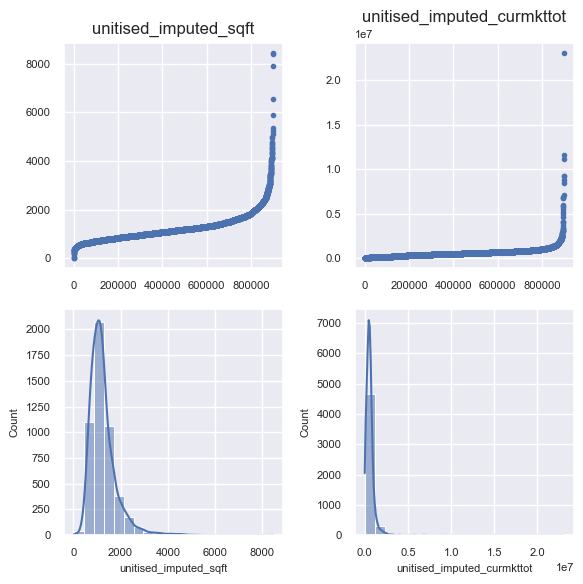

In [200]:
num_columns = ['unitised_imputed_sqft','unitised_imputed_curmkttot']
iter_len = len(num_columns)

fig, axs = plt.subplots(2,iter_len)
fig.set_size_inches(3*iter_len,3*2)

for i in range(iter_len):
    s = sample[num_columns[i]].sort_values()
    x = s.index.sort_values()
    axs[0,i].scatter(x=x,y=s,marker='.')
    axs[0,i].set_title(num_columns[i])
    sns.histplot(sample,x=num_columns[i],bins=20,kde=True,ax=axs[1,i])

plt.tight_layout()
    

**Transformations**
* Continuous data is extremely non normal - compare distributions for best transformation
* Log transformation worked well for square footage and market value


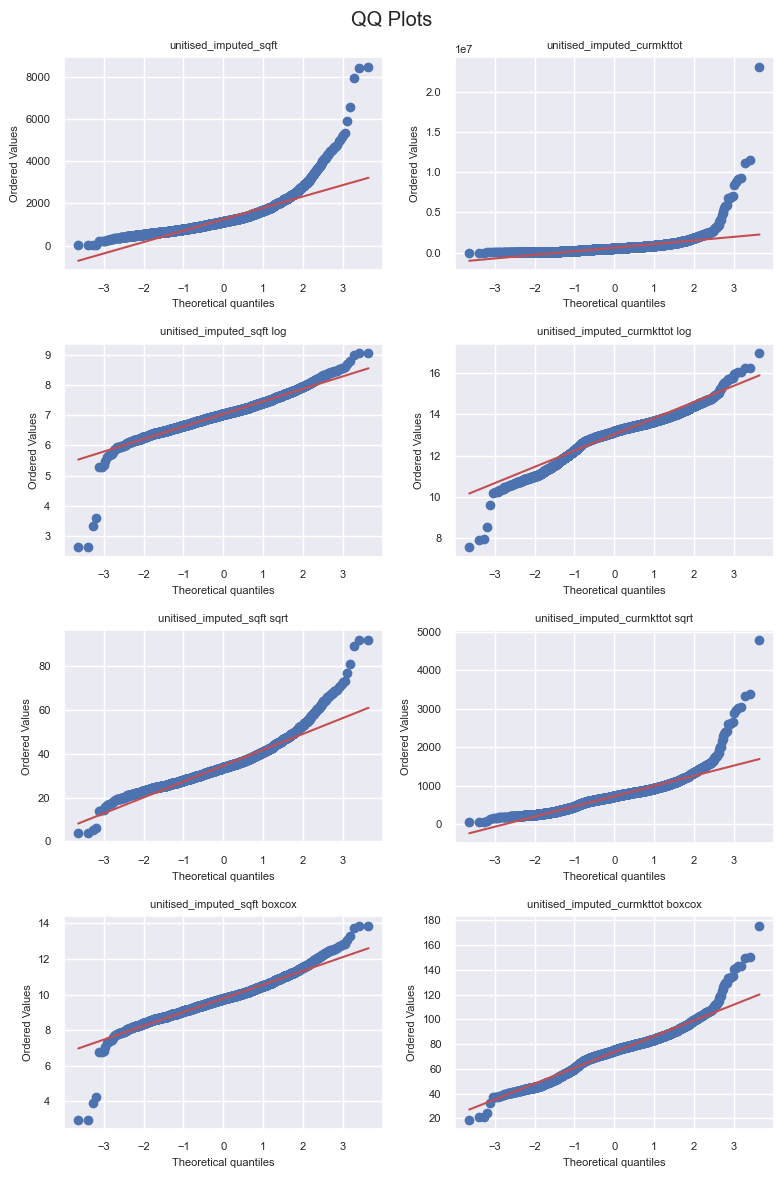

In [201]:
fig, axs = plt.subplots(4,iter_len)
fig.set_size_inches(4*iter_len,4*3)
fig.suptitle('QQ Plots')

for i in range(iter_len):
    s = sample[num_columns[i]]
    prob = stats.probplot(s, dist=stats.norm, plot=axs[0,i],)
    axs[0,i].set_title(num_columns[i],fontsize=8)

    st = np.log(s)
    prob_t = stats.probplot(st, dist=stats.norm, plot=axs[1,i])
    axs[1,i].set_title(num_columns[i] + " " + "log", fontsize=8)

    sq = np.sqrt(s)
    prob_t = stats.probplot(sq, dist=stats.norm, plot=axs[2,i])
    axs[2,i].set_title(num_columns[i] + " " + "sqrt", fontsize=8)

    sb, _ = stats.boxcox(s)
    prob_t = stats.probplot(sb, dist=stats.norm, plot=axs[3,i])
    axs[3,i].set_title(num_columns[i] + " " + "boxcox", fontsize=8)

plt.tight_layout()


In [202]:
# log scaling
df['log_curmkttot'] = np.log(df['unitised_imputed_curmkttot'])
df['log_gross_sqft'] = np.log(df['unitised_imputed_sqft'])

/Users/kmazurczyk/Desktop/AirBnB-Price-Predictor/airbnbenv/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


## Drop Rows/Columns
* Drop rows with valref - it indicates duplicates in the dataset

In [203]:
# valref - properties that are double counted with another listing
df.loc[df['valref']=='Y'].head()

,bldg_class,boro,housenum_lo,housenum_hi,units,coop_apts,street_name,zip_code,owner,land_area,bld_story,gross_sqft,zoning,curmkttot,newdrop,noav,aptno,valref,classification,description,land_area_is_zero,gross_sqft_is_zero,curmkttot_is_zero,imputed_gross_sqft_median,imputed_curmkttot_median,residential_units,unitised_sqft,unitised_imputed_sqft,unitised_curmkttot,unitised_imputed_curmkttot,log_curmkttot,log_gross_sqft
41880,C1,Manhattan,2149,2149,8,8,2 AVENUE,10029,2149 SECOND AVENUE CORP.,1981,4.0,5120,R9A,622000,N,N,NaN,Y,WALK UP APARTMENTS,OVER SIX FAMILIES WITHOUT STORES,False,False,False,5120,622000,8,640.0,640.0,77750.0,77750.0,11.261254,6.461468
142478,B1,Bronx,1506,1506,2,2,WATERSTONE DRIVE,10461,"MUJO, DONIKA",3503,2.0,2046,R4A,1023000,N,N,NaN,Y,TWO FAMILY DWELLINGS,TWO FAMILY BRICK,False,False,False,2046,1023000,2,1023.0,1023.0,511500.0,511500.0,13.145103,6.930495
237313,D7,Brooklyn,16,NaN,380,378,DUPONT STREET,11222,GREENPOINT LANDING LOT 6 LLC,20890,40.0,464327,R8,2089000,N,N,NaN,Y,ELEVATOR APARTMENTS,ELEVATOR APT; SEMI-FIREPROOF WITH STORES,False,False,False,464327,2089000,378,1228.0,1228.0,5526.0,5526.0,8.617220,7.113142
553275,A3,Queens,5-12,5-12,1,1,PARSONS BOULEVARD,11357,"CHEN, PINGHANG",8865,2.0,2968,R1-2,1795000,N,N,NaN,Y,ONE FAMILY DWELLINGS,LARGE SUBURBAN RESIDENCE,False,False,False,2968,1795000,1,2968.0,2968.0,1795000.0,1795000.0,14.400516,7.995644
788748,B1,Staten,61,63,2,2,WATCHOGUE ROAD,10314,"BORYSZEWSKI, MARIUSZ",4086,2.0,1512,R3-1,690000,N,N,NaN,Y,TWO FAMILY DWELLINGS,TWO FAMILY BRICK,False,False,False,1512,690000,2,756.0,756.0,345000.0,345000.0,12.751300,6.628041


In [204]:
# majority of valref listings do not have a curmktot - so let's eliminate these rows to avoid duplicates
df = df.loc[df['valref'] != 'Y']
df.drop('valref',axis=1,inplace=True)

/var/folders/m7/3zdgjklj6csfvb86kltb13hr0000gn/T/ipykernel_56108/774266583.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('valref',axis=1,inplace=True)


## Save for Geocoding

In [205]:
df.to_csv('NYC_Valuations_Data.csv')

# EDA
* select columns for EDA and ML - we don't need the ID columns and we don't need duplicated variables

In [206]:
# select columns for EDA
eda_df = df[['boro',
             'classification',
             #'unitised_imputed_curmkttot','unitised_imputed_sqft',
             'log_curmkttot',
             'log_gross_sqft',
             'newdrop',
             'noav']]

eda_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 877591 entries, 0 to 900306
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   boro            877591 non-null  object 
 1   classification  877591 non-null  object 
 2   log_curmkttot   877591 non-null  float64
 3   log_gross_sqft  877591 non-null  float64
 4   newdrop         877591 non-null  object 
 5   noav            877591 non-null  object 
dtypes: float64(2), object(4)
memory usage: 46.9+ MB


### Classification Distributions

/var/folders/m7/3zdgjklj6csfvb86kltb13hr0000gn/T/ipykernel_56108/2479388020.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(labels=axs[0].get_xticklabels(),rotation=45)
/var/folders/m7/3zdgjklj6csfvb86kltb13hr0000gn/T/ipykernel_56108/2479388020.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(labels=axs[1].get_xticklabels(),rotation=45)


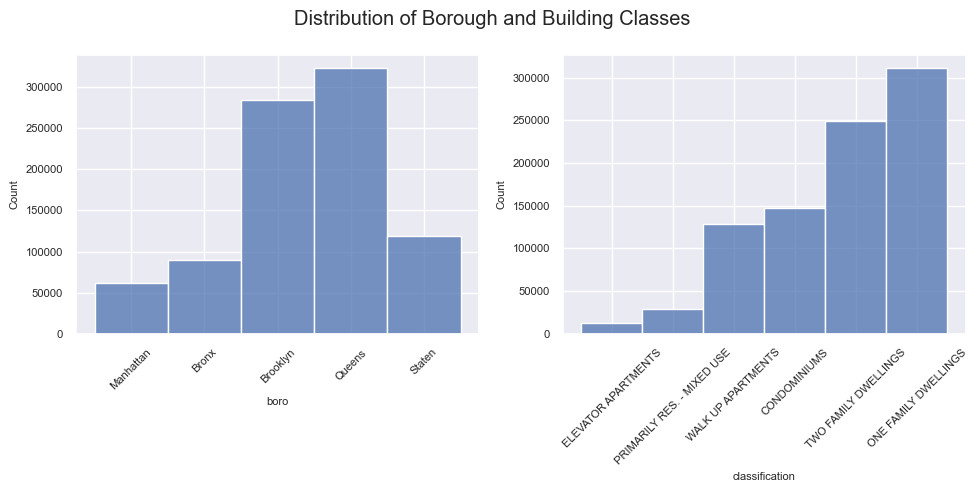

In [207]:
fig, axs = plt.subplots(1,2)
fig.set_size_inches(10,5)
fig.suptitle('Distribution of Borough and Building Classes')

sns.histplot(eda_df, x='boro', ax=axs[0])
axs[0].set_xticklabels(labels=axs[0].get_xticklabels(),rotation=45)

sns.histplot(eda_df, x='classification', ax=axs[1])
axs[1].set_xticklabels(labels=axs[1].get_xticklabels(),rotation=45)

plt.tight_layout()

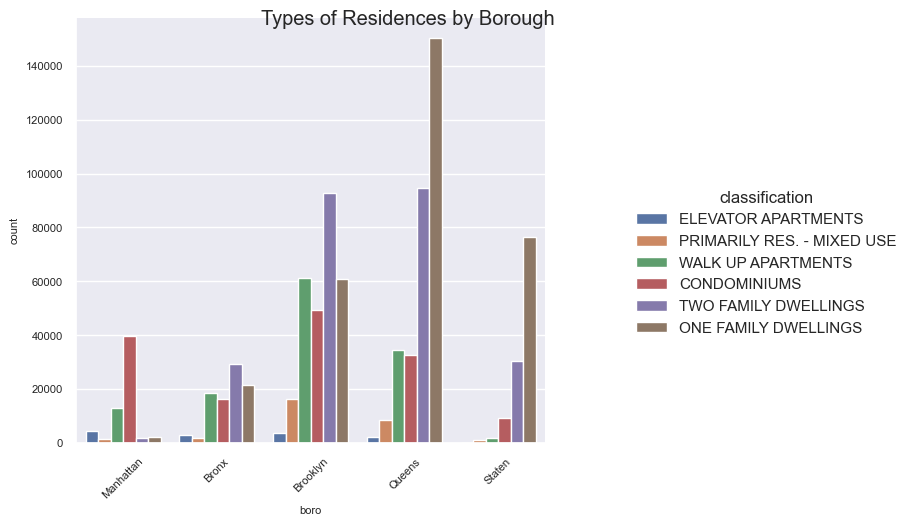

In [210]:
g = sns.catplot(eda_df, x='boro', hue='classification', kind='count')
g.figure.set_size_inches(10,5)
g.figure.suptitle('Types of Residences by Borough')
g.set_xticklabels(labels=eda_df['boro'].unique(), rotation = 45)

In [236]:
boro_inventory = eda_df[['boro','log_curmkttot']].groupby('boro').count().T
boro_inventory

boro,Bronx,Brooklyn,Manhattan,Queens,Staten
log_curmkttot,89706,284030,61908,322834,119113


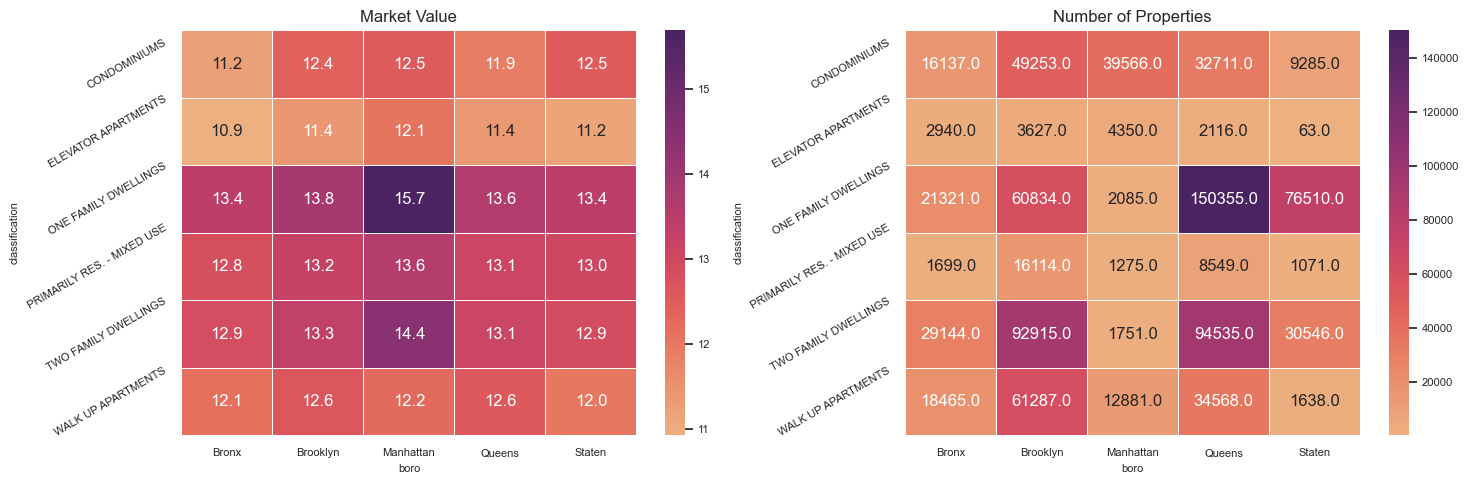

In [252]:
market_values_pivot = eda_df.pivot_table(index='classification',columns='boro',values='log_curmkttot')
inventory_pivot = eda_df.pivot_table(index='classification',columns='boro',values='log_curmkttot',aggfunc='count')

boro_market_values = eda_df[['log_curmkttot','boro']].groupby('boro').sum()
boro_gross_sqft = eda_df[['log_gross_sqft','boro']].groupby('boro').sum()
boro_inventory = eda_df[['boro','log_curmkttot']].groupby('boro').count()

fig, axs = plt.subplots(1,2)
fig.set_size_inches(15,5)

sns.heatmap(market_values_pivot, ax=axs[0], annot=True, fmt='.1f', linewidth=.5, cmap=sns.color_palette('flare',as_cmap=True))
axs[0].set_title('Market Value')
axs[0].set_yticklabels(axs[0].get_yticklabels(), rotation=30)

sns.heatmap(inventory_pivot, ax=axs[1], annot=True, fmt='.1f', linewidth=.5, cmap=sns.color_palette('flare',as_cmap=True))
axs[1].set_title('Number of Properties')
axs[1].set_yticklabels(axs[1].get_yticklabels(), rotation=30)

plt.tight_layout()



### Correlated Variables

In [156]:
eda_df = pd.get_dummies(eda_df)

In [157]:
eda_df_corr = eda_df.corr().round(2)
eda_df_corr['log_curmkttot'].sort_values(ascending=False)

log_curmkttot                                1.00
log_gross_sqft                               0.69
classification_ONE FAMILY DWELLINGS          0.52
boro_Queens                                  0.11
classification_TWO FAMILY DWELLINGS          0.08
boro_Staten                                  0.07
boro_Brooklyn                                0.05
newdrop_N                                    0.04
classification_PRIMARILY RES. - MIXED USE    0.03
noav_N                                       0.01
noav_Y                                      -0.01
newdrop_Y                                   -0.04
boro_Manhattan                              -0.14
boro_Bronx                                  -0.22
classification_ELEVATOR APARTMENTS          -0.23
classification_WALK UP APARTMENTS           -0.27
classification_CONDOMINIUMS                 -0.45
Name: log_curmkttot, dtype: float64

<Axes: >

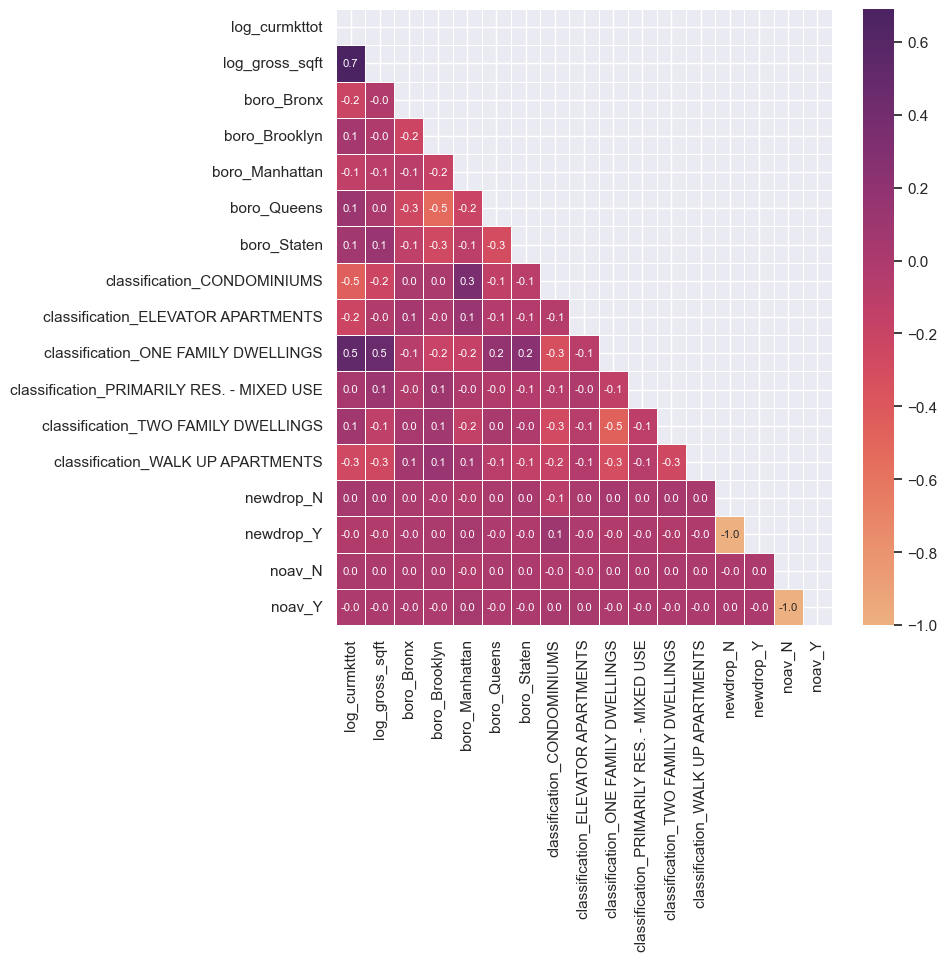

In [158]:
sns.set(rc={"figure.figsize":(8,8)})

mask = np.full_like(eda_df_corr,0)
for i in range(len(mask)):
    for j in range(len(mask[0])):
        if i <= j:
            mask[i][j] = 1

sns.heatmap(eda_df_corr,annot=True,mask=mask,annot_kws={"size":8},fmt='.1f',linewidth=.5, cmap=sns.color_palette('flare',as_cmap=True))

* Market value and gross sq ft are strongly correlated. 
* Market value and single family homes are moderately correlated, this makes sense because these will have high sq ft
* Condos (smaller sq ft) and Bronx neighborhood moderately detract.
* Other variables contribute little/no value - we can definitely remove 'noav' and 'newdrop', and we can potentially engineer a binary 'single family home' to see if that improves the contribution of the CLASSIFICATION variable

In [ ]:
# load geo visualizations
# https://data.cityofnewyork.us/Health/Modified-Zip-Code-Tabulation-Areas-MODZCTA-/pri4-ifjk/data